In [1]:
#!pip install geopandas

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

import re
import pickle
import os
from collections import defaultdict
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words("english")

import gensim

import sys

path_folder = (os.path.abspath(os.path.join((os.path.abspath(os.path.join(os.getcwd(), os.pardir))),os.pardir)))

google_colab = 0
if google_colab == 1:
    from google.colab import drive
    drive.mount('/content/drive/')
    path_folder = "/content/drive/MyDrive/dsprojects/dsproject_grev/"

sys.path.insert(0, path_folder+"/src/features/")
import util

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
USING_SPARK = 0

In [4]:
DATASET_VERSION = ["FULL", "FILTER"][1]  
DROP_ONE_TIME_APPEARANCES = 1
DROP_SEPARATED_ONE_TIME_APPEARANCES = 0
USING_PICS = 0

In [5]:
reviews_dataset_reader = util.Reviews_Dataset_Reader(
    path_folder, 
    DATASET_VERSION, 
    USING_PICS,
    USING_SPARK,
    DROP_ONE_TIME_APPEARANCES, 
    DROP_SEPARATED_ONE_TIME_APPEARANCES,
)

In [6]:
_ = reviews_dataset_reader.build_reviews_df()

1it [00:17, 17.87s/it]
100%|████████████████████████████████████████████████████████████████████████| 11015/11015 [00:00<00:00, 338101.80it/s]


In [7]:
reviews_df = reviews_dataset_reader.reviews_df

In [8]:
review_text_column_name = "review_text"
rating_column_name = "rating"
binarized_rating_column_name = "binarized_rating"
target_column_name = binarized_rating_column_name

rating_column = reviews_df[rating_column_name]
binarized_rating_column = (rating_column > 4).astype(int)
target_column = binarized_rating_column
reviews_df[target_column_name] = target_column

review_text_column = reviews_df[review_text_column_name]
review_text_column = review_text_column.fillna("")
review_text_column = util.clean_text_column(review_text_column)
reviews_df[review_text_column_name] = review_text_column

X = reviews_df
y_column_name = target_column_name
y = reviews_df[y_column_name]
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y)

In [9]:
def get_negative_words_of_stop_words_list(stop_words_list):
    negative_words = ["no","not","t","nor","against"] # constant
    contraction_not_words = [word for word in stop_words_list if word[-2:]=="'t"]
    contraction_not_words_pre_apostrophe = [word[:-2] for word in contraction_not_words]
    negative_words += contraction_not_words
    negative_words += contraction_not_words_pre_apostrophe
    return negative_words

stop_words = stopwords.words("english")
negative_words = get_negative_words_of_stop_words_list(stop_words)
#raw_recipes_df = pd.read_csv(os.path.join(PATH_FOLDER,"RAW_recipes.csv"))
for word in negative_words: stop_words.remove(word);
#stop_words_list += (cooking_related_words)

print("Removed stop words")
####

Removed stop words


In [11]:
np.random.seed(1)
reviews_df = reviews_df.sample(frac=0.75)
threshold = int(reviews_df.shape[0]*0.75)
train_reviews_df = reviews_df.iloc[:threshold,]
#train_reviews_df["binarized_rating"].mean()

0.6277490244738689

In [12]:
test_reviews_df = reviews_df.iloc[threshold:,]
#test_reviews_df["binarized_rating"].mean()

0.6285448400842435

In [13]:
pipeline = Pipeline([('count', CountVectorizer(stop_words=stop_words)),
              ('tfidf', TfidfTransformer())])

vectorizer = util.Temp_Recipe_Vectorizer_Builder(pipeline)

tfidf_group_collapser = util.Tfidf_Group_Collapser(
    train_reviews_df,
    target_column_name,
    review_text_column_name,
    vectorizer
)

In [14]:
result = tfidf_group_collapser.collapse_by_strjoin()

100%|█████████████████████████████████████████████████████████████████████████| 22800/22800 [00:00<00:00, 24486.62it/s]


In [15]:
tfidf_group_collapser.temp_labels

[1, 0]

In [16]:
result = tfidf_group_collapser.build_temp_word2label_df()

In [19]:
############
N = 100
top_n_tfidf_negative_skewed_words_by_contrast_list = (
    result[result["arg_label"]==1].sort_values(["stdev"],ascending=False)["word"].head(N).values
)
learned_mapping = dict(zip(list(top_n_tfidf_negative_skewed_words_by_contrast_list),list(range(N))))
learned_count_vectorizer = CountVectorizer(vocabulary=learned_mapping)

##########

X_train = learned_count_vectorizer.transform(train_reviews_df[review_text_column_name]).tocsc().A

y_train = 1-(train_reviews_df[target_column_name].astype(int))

In [20]:
X_test = learned_count_vectorizer.transform(test_reviews_df[review_text_column_name]).tocsc().A

y_test = 1-(test_reviews_df[target_column_name].astype(int))

In [21]:
###########

def fit_model_subset(X_train_, y_train_):
    model = LogisticRegression(class_weight="balanced",max_iter=300)
    model.fit(X_train_, y_train_)
    predictions = model.predict(X_train_)
    acc = np.mean(predictions==y_train_)
    print(acc)
    #confusion_matrix_array = confusion_matrix(y_train_, predictions, normalize="true")
    #confusion_matrix_array
    return model

def undersampling_fitting(
    X_train_, 
    y_train_,
    num_subset_model_fittings = 10
    ):
    good_reviews_indices = np.where(y_train_ == 0)[0]
    bad_reviews_indices = np.where(y_train_ == 1)[0]
    print(len(bad_reviews_indices)/(len(bad_reviews_indices) + len(good_reviews_indices)))
    subset_size = bad_reviews_indices.shape[0] # len(good_reviews_indices) // num_subset_model_fittings
    subset_models = []

    for i in (range(num_subset_model_fittings)):
        good_reviews_subset_indices = np.random.choice(good_reviews_indices,size=subset_size)

        good_reviews_subset = X_train_[good_reviews_subset_indices,:]
        bad_reviews = X_train_[bad_reviews_indices,:]

        X_train_subset = np.vstack([good_reviews_subset, bad_reviews])
        y_train_subset = np.array(
            [0 for _ in range(good_reviews_subset.shape[0])] + \
            [1 for _ in range(bad_reviews.shape[0])]
        )

        shuffler_indices = np.arange((good_reviews_subset.shape[0]) + (bad_reviews.shape[0]))
        np.random.shuffle(shuffler_indices)

        X_train_subset_shuffled = X_train_subset[shuffler_indices]
        y_train_subset_shuffled = y_train_subset[shuffler_indices]

        #print(X_train_subset_shuffled.shape)

        subset_model = fit_model_subset(X_train_subset_shuffled, y_train_subset_shuffled)
        subset_models.append(subset_model)

    return subset_models

##############

subset_models = undersampling_fitting(X_train, y_train, 10)

model_coefs = np.array([model.coef_ for model in subset_models])
model_intercepts = np.array([model.intercept_ for model in subset_models])
model_coefs = np.squeeze(model_coefs,1)
model_intercepts = np.squeeze(model_intercepts,1)
model_coefs_std = np.std(model_coefs, axis=1, keepdims=1,ddof=0)
model_coefs_ = model_coefs / model_coefs_std
model_coefs_avg = np.mean(model_coefs_,axis=0)
model_intercepts_ = model_intercepts #/ np.squeeze(model_coefs_std,1)
model_intercepts_avg = np.mean(model_intercepts_)

########################

sigmoid = lambda x: 1/(1+(np.exp(-x)))

predictions_prob_undersampled = sigmoid((X_test @ np.expand_dims(model_coefs_avg,1)+model_intercepts_avg))

predictions = (predictions_prob_undersampled > 0.5).astype(int)

predictions = np.squeeze(predictions,1)

y_test.shape, predictions.shape

acc = np.mean(predictions==y_test)
print(acc)

0.372250975526131
0.6433991228070175
0.6462280701754386
0.6455263157894737
0.647061403508772
0.6458771929824562
0.6447368421052632
0.645438596491228
0.6454166666666666
0.6440570175438597
0.6450877192982456
0.6571974335112896


In [29]:
confusion_matrix_array = confusion_matrix(y_test, predictions, normalize="true")
print(confusion_matrix_array)
#f, ax = plt.subplots(figsize=(9, 9))
#heatmap = sns.heatmap(confusion_matrix_array, annot=True)

[[0.69181018 0.30818982]
 [0.40137131 0.59862869]]


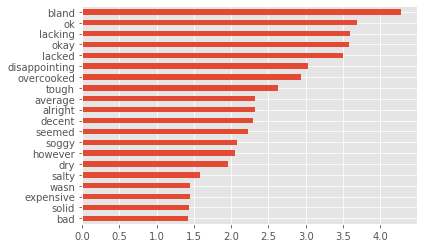

In [30]:
pd.Series(index=top_n_tfidf_negative_skewed_words_by_contrast_list, 
          data=model_coefs_avg).sort_values(ascending=False).head(20)[::-1].plot.barh()#(type="barh")